In [1]:
import sys
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
import albumentations as A
import torchvision.transforms as transforms
from data_utils.utils import get_iid_to_ann, load_img, paths

sys.path.append('../models/de_potr')
from coco_dataset.coco_dataset import COCODataset, get_final_preds, COCODatasetPredict

In [2]:
images_path = paths["train_img"]
train_ann_path = paths["train_ann"]
val_ann_path = paths["val_ann"]

output_path = "data/output/visualization/"

In [3]:
iid_to_ann, iid_to_idx = get_iid_to_ann(val_ann_path, train_ann_path)

In [4]:
transforms = transforms.Compose([transforms.ToTensor()])
aug_all = A.ReplayCompose([A.HorizontalFlip(p=5),
                           A.RandomBrightnessContrast(p=0.6, brightness_limit=0.15, contrast_limit=0.15),
                           A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
                           A.Rotate(p=0.4, limit=5, border_mode=1),
                           A.GaussianBlur(p=0.5, blur_limit=(3, 5))
                           ])
flip = A.ReplayCompose([A.HorizontalFlip(p=1)])
rbc = A.ReplayCompose([A.RandomBrightnessContrast(p=1, brightness_limit=0.15, contrast_limit=0.15)])
shift = A.ReplayCompose([A.RGBShift(p=1, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)])
rot = A.ReplayCompose([A.Rotate(p=1, limit=5, border_mode=1)])
gb = A.ReplayCompose([A.GaussianBlur(p=1, blur_limit=(3, 5))])
augs = [flip, rbc, shift, rot, gb]
titles = ["Original image", "Horizontal flip", "Brightness and contrast", "Color shift", "Rotation", "Gaussian blur"]

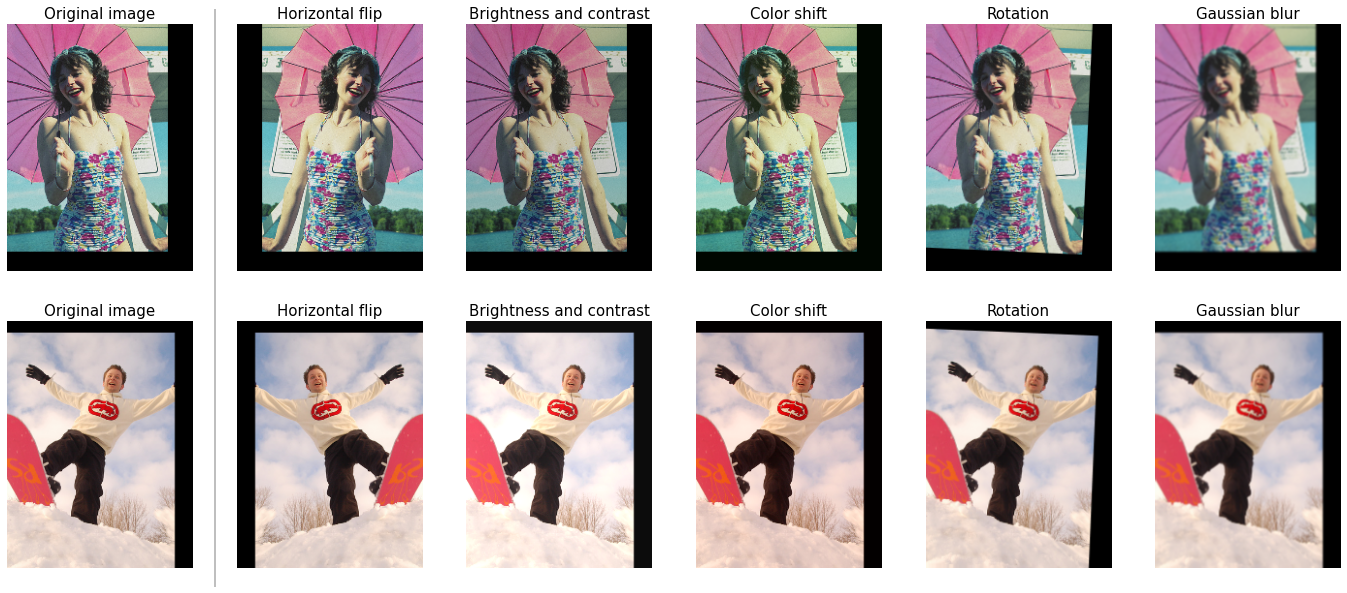

In [5]:
random.seed(28)
image_ids = [36, 2583]
image_names = [f"{str(iid).zfill(12)}.jpg" for iid in image_ids]
annots = []
imgs = {}
for i in range(len(image_ids)):
    annots.extend(iid_to_ann[image_ids[i]])
    imgs[image_ids[i]] = load_img(images_path, image_names[i])

data = COCODatasetPredict(annots, imgs)
crop_imgs = []
for i in range(len(image_ids)):
    img, meta = data[i]
    aim = [img]
    for a in augs:
        aimg = a(image=img)['image']
        aim.append(aimg)
    crop_imgs.append(aim)

fig, axs = plt.subplots(len(image_ids), len(augs) + 1, figsize=[6*4, 2*5])

for i in range(len(crop_imgs)):
    for j in range(len(crop_imgs[0])):
        axs[i][j].imshow(crop_imgs[i][j])
        axs[i][j].set_title(titles[j], fontsize=15)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        axs[i][j].spines['bottom'].set_visible(False)
        axs[i][j].spines['left'].set_visible(False)

axs[0][0].plot([1/4.05, 1/4.05], [0.1, 0.9], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
plt.show()
fig.savefig(output_path + 'individual_aug.pdf', bbox_inches='tight')

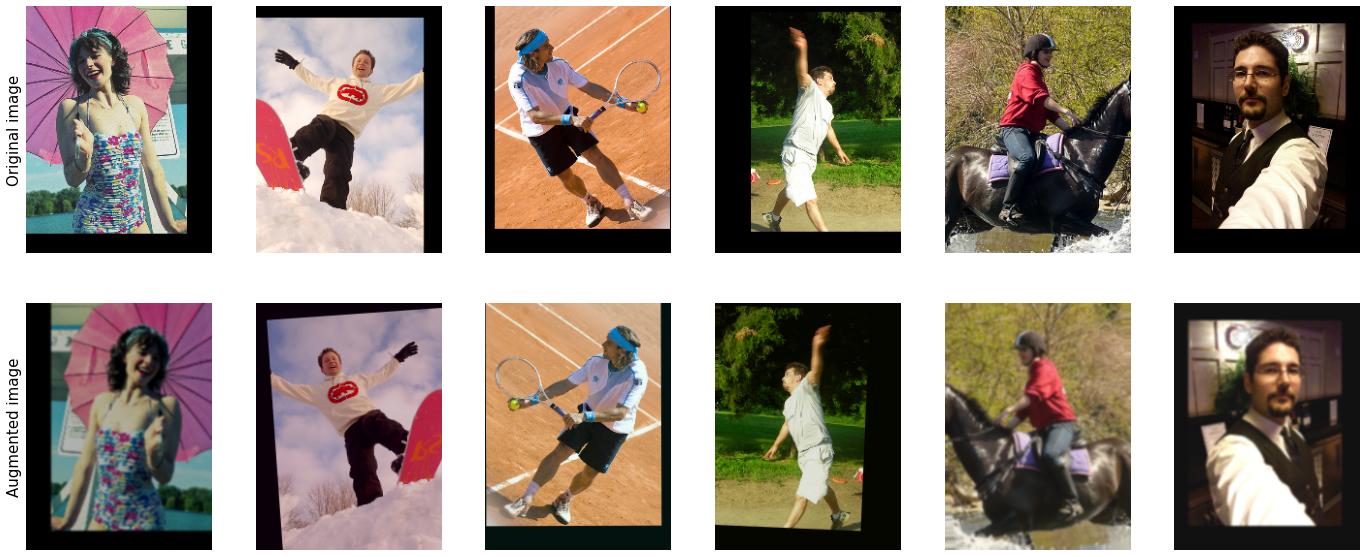

In [6]:
random.seed(28)
image_ids = [36, 2583, 962, 1183, 398279, 402420]
image_names = [f"{str(iid).zfill(12)}.jpg" for iid in image_ids]
annots = []
imgs = {}
for i in range(len(image_ids)):
    annots.extend(iid_to_ann[image_ids[i]])
    imgs[image_ids[i]] = load_img(images_path, image_names[i])

data = COCODatasetPredict(annots, imgs)
crop_imgs = []
img_aug = []
for i in range(len(image_ids)):
    img, meta = data[i]
    crop_imgs.append(img)
img_aug.append(crop_imgs)

aim = []
for i in crop_imgs:
    aimg = aug_all(image=i)['image']
    aim.append(aimg)
img_aug.append(aim)

fig, axs = plt.subplots(2, len(image_ids), figsize=[6*4, 2*5])

for i in range(len(img_aug)):
    for j in range(len(img_aug[0])):
        axs[i][j].imshow(img_aug[i][j])
        if j == 0 and i ==0:
            axs[i][j].set_ylabel("Original image", fontsize=15)
        if j == 0 and i ==1:
            axs[i][j].set_ylabel("Augmented image", fontsize=15)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        axs[i][j].spines['bottom'].set_visible(False)
        axs[i][j].spines['left'].set_visible(False)

fig.savefig(output_path + 'aug.pdf', bbox_inches='tight')